### **Three ways to analyze AB test**


**A/B test objective**:

To evaluate the impact of the new version (Test) on user behavior compared to the current solution (Control).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# This command makes plots appear in the notebook
%matplotlib inline

# Packages for the function
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings('ignore')

Part 1: EDA

In [3]:
df = pd.read_csv("/content/ab_test_results_aggregated_views_clicks_6.csv")
df

,user_id,group,views,clicks
0,1,control,3.0,0.0
1,2,control,1.0,0.0
2,3,control,3.0,1.0
3,4,control,5.0,0.0
4,5,control,2.0,0.0
...,...,...,...,...
79995,79996,test,4.0,0.0
79996,79997,test,2.0,0.0
79997,79998,test,13.0,1.0
79998,79999,test,2.0,0.0


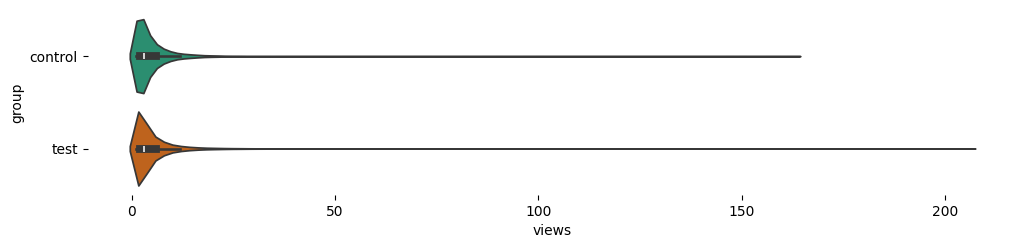

In [4]:
figsize = (12, 1.2 * len(df['group'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='views', y='group', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

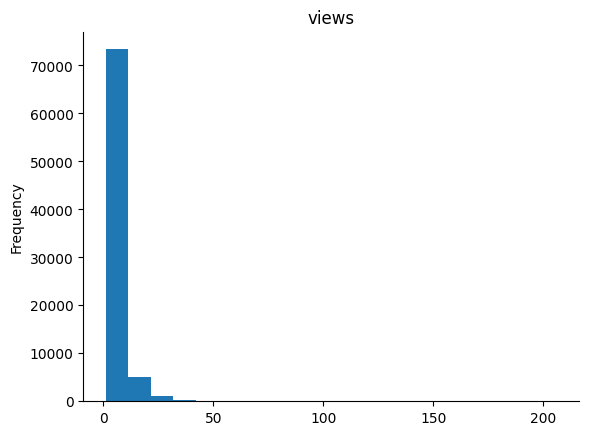

In [5]:
from matplotlib import pyplot as plt
df['views'].plot(kind='hist', bins=20, title='views')
plt.gca().spines[['top', 'right',]].set_visible(False)

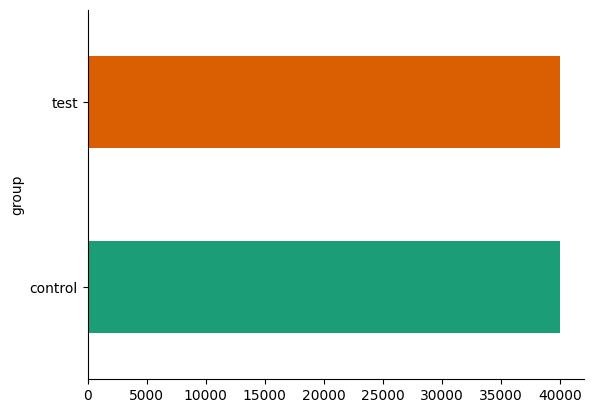

In [6]:
df.groupby('group').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  80000 non-null  int64  
 1   group    80000 non-null  object 
 2   views    80000 non-null  float64
 3   clicks   80000 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.4+ MB


In [8]:
df.isna().sum()

,0
user_id,0
group,0
views,0
clicks,0


In [9]:
df.describe()

,user_id,views,clicks
count,80000.000000,80000.000000,80000.000000
mean,40000.500000,4.998263,0.373437
std,23094.155105,5.915452,0.746015
min,1.000000,1.000000,0.000000
25%,20000.750000,2.000000,0.000000
50%,40000.500000,3.000000,0.000000
75%,60000.250000,6.000000,1.000000
max,80000.000000,206.000000,21.000000


In [10]:
df.groupby('group').size()

,0
group,
control,40000
test,40000


Part 2: Tests


Option One: AB test calculator.

In [11]:
df.groupby('group').sum()

,user_id,views,clicks
group,,,
control,800020000,199242.0,13829.0
test,2400020000,200619.0,16046.0


https://abtestguide.com/calc/

**Views rate**. The test result is not significant.
The observed difference in conversion rate (0.69%) isn't big enough to declare a significant winner. There is no real difference in performance between A and B or you need to collect more data.

**Read Rate**. Significant test result!
Variation B's observed conversion rate (40.12%) was 16.03% higher than variation A's conversion rate (34.57%). You can be 95% confident that this result is a consequence of the changes you made and not a result of random chance.



Option Two: Bootstrap

In [12]:
# Click-through rate
# to avoid dividing by zero and getting NaN
df['ctr'] = np.where(df['views'] == 0, 0, df['clicks'] / df['views'])

df.head()

,user_id,group,views,clicks,ctr
0,1,control,3.0,0.0,0.000000
1,2,control,1.0,0.0,0.000000
2,3,control,3.0,1.0,0.333333
3,4,control,5.0,0.0,0.000000
4,5,control,2.0,0.0,0.000000


In [13]:
df.describe()

,user_id,views,clicks,ctr
count,80000.000000,80000.000000,80000.000000,80000.000000
mean,40000.500000,4.998263,0.373437,0.074765
std,23094.155105,5.915452,0.746015,0.166210
min,1.000000,1.000000,0.000000,0.000000
25%,20000.750000,2.000000,0.000000,0.000000
50%,40000.500000,3.000000,0.000000,0.000000
75%,60000.250000,6.000000,1.000000,0.076923
max,80000.000000,206.000000,21.000000,1.000000


In [14]:
df.groupby('group')['ctr'].agg(['count', 'mean', 'median'])

,count,mean,median
group,,,
control,40000,0.069166,0.0
test,40000,0.080363,0.0


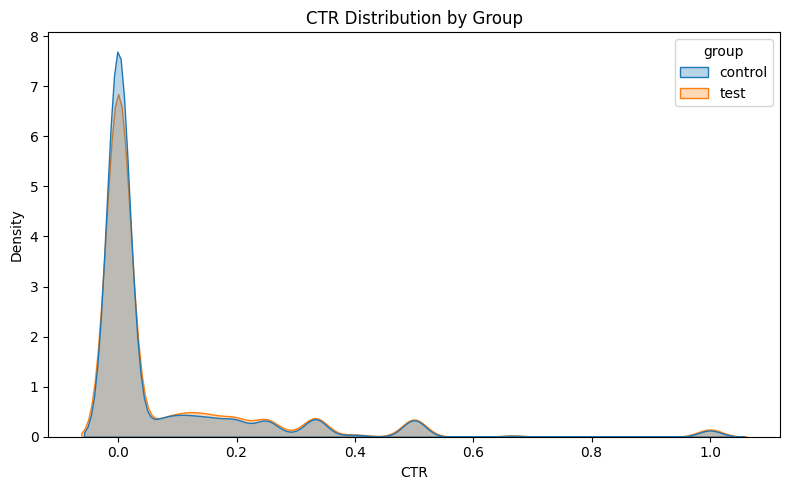

In [15]:
# Set the figure size
plt.figure(figsize=(8, 5))
# Plot CTR Distribution by Group, KDE
sns.kdeplot(data=df, x='ctr', hue='group', fill=True, alpha=0.3)
plt.title('CTR Distribution by Group')
plt.xlabel('CTR')
# Display the plot
plt.tight_layout()
plt.show()

In [16]:
# Creating a list with bootstrapped means for each AB-group
boot_ctr = []

for i in range(1000):
    boot_mean = (
        df.sample(frac=1, replace=True)
          .groupby('group')['ctr']
          .mean()
    )
    boot_ctr.append(boot_mean)

# Transforming the list to a DataFrame
boot_ctr = pd.DataFrame(boot_ctr)
boot_ctr.head()

group,control,test
ctr,0.071022,0.080714
ctr,0.069750,0.081234
ctr,0.069432,0.079972
ctr,0.069153,0.079674
ctr,0.068920,0.080555


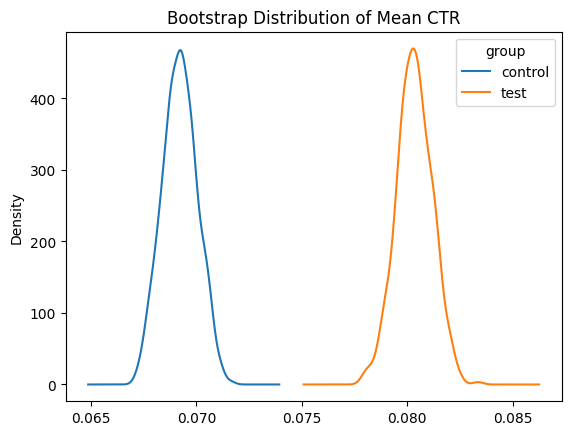

In [17]:
# A Kernel Density Estimate plot of the bootstrap distributions
boot_ctr.plot(kind='kde')
plt.title('Bootstrap Distribution of Mean CTR')
plt.show()

In [18]:
# Adding a column with the % difference between the two AB-groups
boot_ctr['diff_pct'] = (boot_ctr['test'] / boot_ctr['control'] - 1) * 100

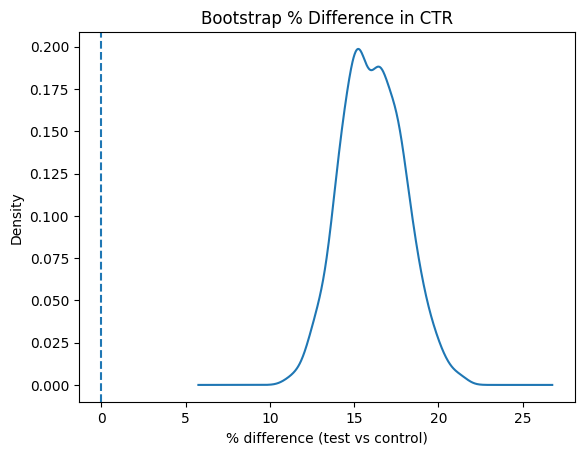

In [19]:
# Ploting the bootstrap % difference
ax = boot_ctr['diff_pct'].plot(kind='kde')
ax.set_xlabel('% difference (test vs control)')
plt.axvline(0, linestyle='--')
plt.title('Bootstrap % Difference in CTR')
plt.show()

In [20]:
#What is the probability that the difference is above 0%?
prob = (boot_ctr['diff_pct'] > 0).mean()
print(f"Probability that test > control: {prob:.2%}")

Probability that test > control: 100.00%


In [21]:
#Confidence Intervals
np.percentile(boot_ctr['diff_pct'], [2.5, 97.5])

array([12.60009927, 19.76621154])

Bootstrap Function

In [22]:
def generate_bootstrap(data, group_col, metric, func, size=1000):
    boot = []

    for i in range(size):
        sample = (
            data
            .sample(frac=1, replace=True)
            .groupby(group_col)[metric]
            .agg(func)
        )
        boot.append(sample)

    return pd.DataFrame(boot)

In [23]:
def bootstrap_check(data, group_col, metric, func='mean', size=1000):

    boot = generate_bootstrap(data, group_col, metric, func, size)

    if {'test', 'control'}.issubset(boot.columns):

        # % uplift test vs control
        boot['diff_pct'] = (boot['test'] / boot['control'] - 1) * 100

        ci_diff = np.percentile(boot['diff_pct'], [2.5, 97.5])
        ci_test = np.percentile(boot['test'], [2.5, 97.5])
        ci_control = np.percentile(boot['control'], [2.5, 97.5])

        print(f"Metric: {metric} ({func})")
        print(f"95% CI control: {ci_control}")
        print(f"95% CI test: {ci_test}")
        print(f"95% CI uplift (%): {ci_diff}")

        # Plot
        ax = boot['diff_pct'].plot(kind='kde')
        plt.axvline(0, linestyle='--')
        ax.set_xlabel('CTR uplift (%) — test vs control')
        plt.title('Bootstrap distribution of CTR uplift')
        plt.show()

        # Probability test > control
        prob = (boot['diff_pct'] > 0).mean()
        print(f"P(test > control): {prob:.2%}")

    else:
        print("Columns 'test' and 'control' not found.")

Metric: ctr (mean)
95% CI control: [0.06761337 0.0708416 ]
95% CI test: [0.07870748 0.08198619]
95% CI uplift (%): [12.47314795 19.88233066]


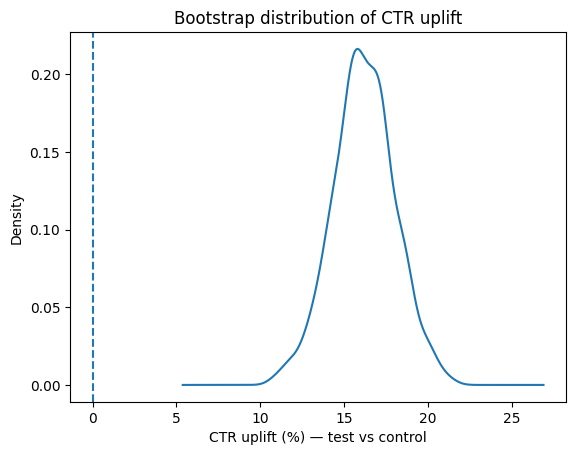

P(test > control): 100.00%


In [24]:
bootstrap_check(
    data=df,
    group_col='group',
    metric='ctr',
    func='mean',
    size=1000
)

Option Three: Test

In [25]:
#check the stats for calculator
df.groupby('group')['ctr'].agg(['count', 'mean', 'std'])

,count,mean,std
group,,,
control,40000,0.069166,0.159626
test,40000,0.080363,0.172363


In [26]:
def AB_Test(dataframe, group, target):

    # Split A/B
    groupA = dataframe[dataframe[group] == "control"][target]
    groupB = dataframe[dataframe[group] == "test"][target]

    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True

    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True

        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True

    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05],
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")

    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]

    # Print Hypothesis
    #print("# A/B Testing Hypothesis")
    #print("H0: A == B")
    #print("H1: A != B", "\n")

    return temp

In [27]:
# Apply A/B Testing
AB_Test(dataframe=df, group = "group", target = "ctr")

,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,5.624710e-26,A/B groups are not similar!


In [28]:
df.columns.tolist()[2:]

['views', 'clicks', 'ctr']

In [29]:
results = []
for target in df.columns.tolist()[2:]:
    result = AB_Test(dataframe=df, group = "group", target = target)
    result["Target"] = target
    results.append(result)

final_result_df = pd.concat(results, ignore_index=True)
# Reorder columns to move the last column to the first position
final_result_df = final_result_df[[final_result_df.columns[-1]] + list(final_result_df.columns[:-1])]
final_result_df

,Target,Test Type,AB Hypothesis,p-value,Comment
0,views,Non-Parametric,Fail to Reject H0,3.838298e-01,A/B groups are similar!
1,clicks,Non-Parametric,Reject H0,1.019243e-25,A/B groups are not similar!
2,ctr,Non-Parametric,Reject H0,5.624710e-26,A/B groups are not similar!


Grouping

In [30]:
#adding the grouping
df['number_of_views'] = pd.cut(
    df['views'],
    bins=[0, 5, 10, float('inf')],
    labels=['1-5', '6-10', '11+']
)

In [31]:
df.head()

,user_id,group,views,clicks,ctr,number_of_views
0,1,control,3.0,0.0,0.000000,1-5
1,2,control,1.0,0.0,0.000000,1-5
2,3,control,3.0,1.0,0.333333,1-5
3,4,control,5.0,0.0,0.000000,1-5
4,5,control,2.0,0.0,0.000000,1-5


In [32]:
def pivot_diff(value, func):
    pivot_df = df.pivot_table(
    index='number_of_views',
    columns='group',
    values= value,
    aggfunc= func,
    observed=False,
    ).fillna(0)

    column_totals = df.groupby('group')[value].agg(func).reindex(pivot_df.columns).fillna(0).to_frame().T
    column_totals.index = [f'Total {value}, {func}']
    pivot_df = pd.concat([pivot_df, column_totals])

    pivot_df['diff_pct'] = (pivot_df['test']/pivot_df['control'] - 1)*100

    return pivot_df

In [33]:
pivot_diff('views', 'count')

group,control,test,diff_pct
1-5,29230,28982,-0.848443
6-10,6934,7050,1.672916
11+,3836,3968,3.441084
"Total views, count",40000,40000,0.000000


In [34]:
def ab_chart(a):
    a[['control', 'test']][:-1].plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
    plt.title(a.index[-1])
    plt.show()
    return a

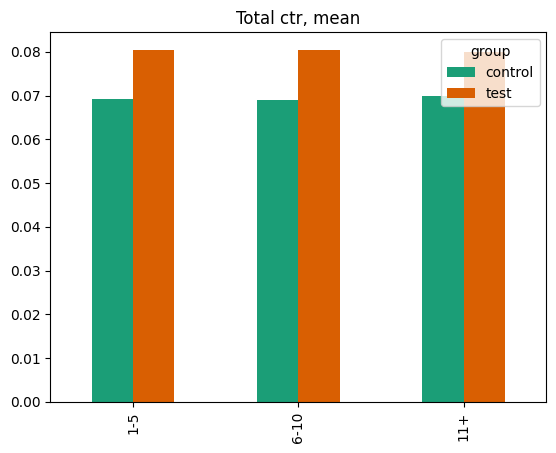

group,control,test,diff_pct
1-5,0.069102,0.080426,16.387970
6-10,0.069034,0.080297,16.315555
11+,0.069891,0.080019,14.491205
"Total ctr, mean",0.069166,0.080363,16.189151


In [35]:
ab_chart(pivot_diff('ctr', 'mean'))

In [36]:
def cis(data, group, metric, func, size=1000):

    boot = generate_bootstrap(data, group, metric, func, size)
    boot['diff'] = (boot['test'] / boot['control'] - 1) * 100
    ci_diff = np.percentile(boot['diff'], [5, 95])

    return ci_diff

In [37]:
r = []

for part in df['number_of_views'].unique():

    subset = df[df['number_of_views'] == part]

    ci_diff = cis(data=subset, group='group', metric='ctr', func='mean', size=1000)

    result_dict = {
        'Number_of_views': part,
        'Target': 'ctr',
        'ci_lower': ci_diff[0],
        'ci_upper': ci_diff[1],
        'confidence': 'ci cross 0' if (ci_diff[0] < 0 < ci_diff[1]) else '90 pct confidence'
    }

    r.append(result_dict)

final_result = pd.DataFrame(r)
final_result.sort_values(by=['Target', 'Number_of_views'], inplace=True)
final_result

,Number_of_views,Target,ci_lower,ci_upper,confidence
0,1-5,ctr,12.469231,20.404927,90 pct confidence
2,11+,ctr,10.738594,18.553675,90 pct confidence
1,6-10,ctr,11.985134,20.594026,90 pct confidence


In [38]:
# Fit the model
model = ols('ctr ~ C(group) * C(number_of_views)', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                                  sum_sq       df          F        PR(>F)
C(group)                        2.507346      1.0  90.858993  1.584029e-21
C(number_of_views)              0.000393      2.0   0.007124  9.929013e-01
C(group):C(number_of_views)     0.002480      2.0   0.044937  9.560582e-01
Residual                     2207.515897  79994.0        NaN           NaN


🔑 Key results

- CTR increased by ~16% in the test group.

- The result is statistically significant (p-value < 0.001).

- The effect is stable across all user segments.

- Traffic distribution between groups is correct

🧪 Statistical confirmation

- The result is confirmed by three independent approaches:

- A/B calculator (aggregated metrics)

- Bootstrap (95% CI uplift ≈ +13% → +20%)

- Non-parametric test (Mann–Whitney)

In all cases:

- CI does not cross 0

- P(Test > Control) ≈ 100%

👥 Segmentation

The effect is positive in all groups:

- low engagement (1–5 views)

- mid (6–10)

- high (11+)

No interaction effect → the solution works equally well for everyone

✅ Business conclusion

The test variant significantly improves user engagement without negatively affecting traffic.
Full rollout (100%) is recommended.